# 1. Import & def

In [3]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime
from datetime import timedelta
import scipy.constants as const
import matplotlib.dates as mdates

# define hte directory for the data
# data folder direcotry
data_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results"
# directory for the results folder to investigate for session 6
results_dir = r'C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# Determine fixed x and y axis limits for all plots that plot for each module
y_limit_module = (0, 15)
x_limit_module = (0, 60)  # Assuming a reasonable range for combined voltages

# Determine fixed x and y axis limits for all plots that plot for the combined inverter
y_limit_inverter = (0, 17)
x_limit_inverter = (0, 1200)  # Adjust for combined voltages

# Option to dynamically calculate vth based on panel temperature
use_dynamic_vth = True  # Set to True to enable dynamic calculation, False to use thermal_voltage_25C

# Option to replace the panel temperature with the temperature, the reason to do this is that the module temperature looks too high but the ambient tmperature looks like module temperature
use_a_T = True  # Set to True to use ambient temperature, False to use module temperature

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)

# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL

# 2. Loop through all data

<string>:251: SyntaxWarning: invalid escape sequence '\{'
<>:251: SyntaxWarning: invalid escape sequence '\{'
<string>:251: SyntaxWarning: invalid escape sequence '\{'
<>:251: SyntaxWarning: invalid escape sequence '\{'
C:\Users\z5183876\AppData\Local\Temp\ipykernel_19940\1397955440.py:251: SyntaxWarning: invalid escape sequence '\{'
  results_folder = os.path.join(base_dir, f"v_from_i_combined\{site_id}_{season}_{now}")
C:\Users\z5183876\AppData\Local\Temp\ipykernel_19940\1397955440.py:174: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')


Season directory found: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\4197100\june


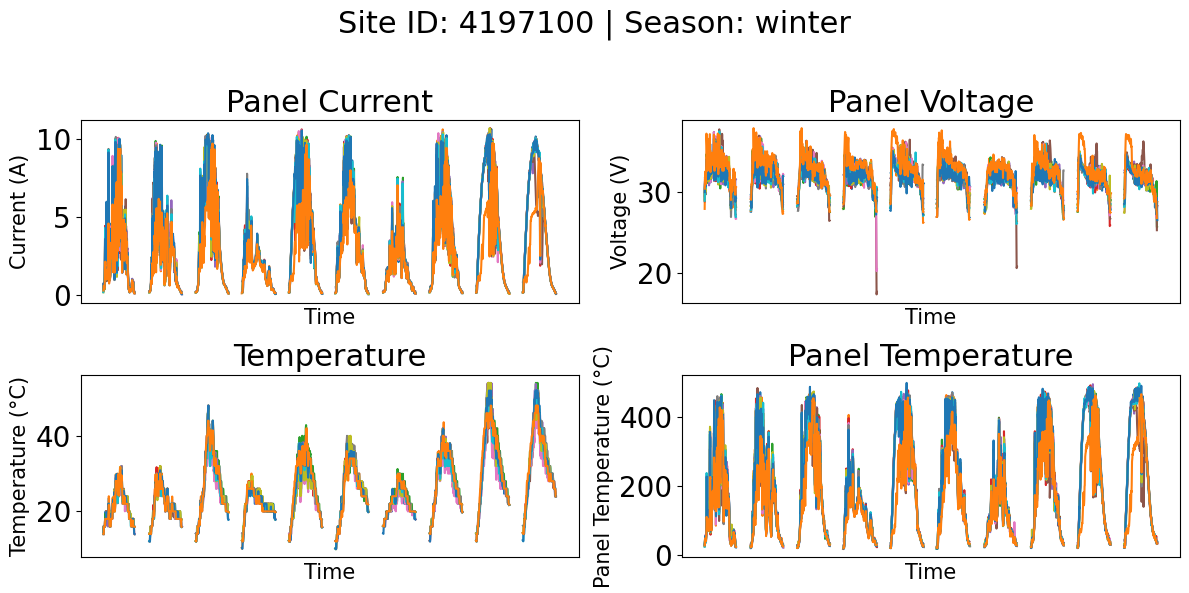

Using ambient temperature
Series Resistance from PAN file: 0.206
Shunt Resistance from PAN file: 1700.0
Number of cells in series from PAN file: 72
Ideality factor from PAN file: 0.973


C:\Users\z5183876\AppData\Local\Temp\ipykernel_19940\1397955440.py:420: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
C:\Users\z5183876\AppData\Local\Temp\ipykernel_19940\1397955440.py:416: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
C:\Users\z5183876\AppData\Local\Temp\ipykernel_199

Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\long_horizontal_2024-06-15_05-55-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\long_horizontal_2024-06-15_06-00-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\long_horizontal_2024-06-15_06-05-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\long_horizontal_2024-06-15_06-10-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\long_horizontal_2024-06-15_06-

C:\Users\z5183876\AppData\Local\Temp\ipykernel_19940\1397955440.py:472: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\combined_iv_curves_long.gif
Excel file saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\iv_sum_data.xlsx
Excel file saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\pmppt_data.xlsx
CSV file saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\j0_data.csv
Combined data exported to: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\4197100_winter_20250430_204307\combined_data_winter_4197100.xlsx
The lengths of Sum of I*V and Pmppt are the same.
Sum of I*V Energy: 2830027.76 W
Pmppt Energy: 2503252.36 W
Sum mismatch: 11.55%
Plot exported to: C:\

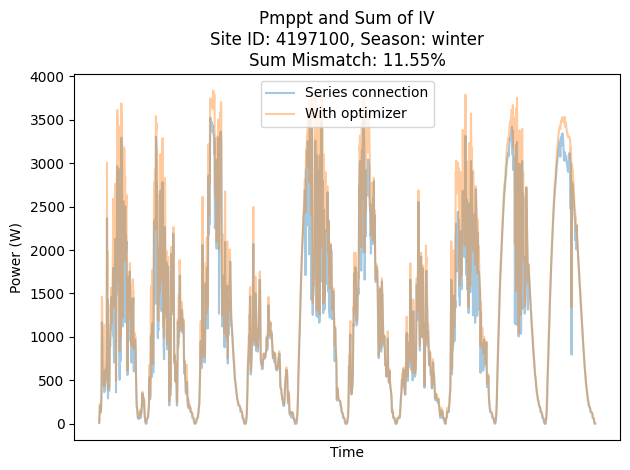

In [4]:
# Get all site_ids from the folder names in data_dir
site_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
site_ids = [folder.split('_')[0] for folder in site_folders]

# create a list of seasons to loop through
seasons = ['spring', 'summer', 'autumn', 'winter']

# # Constants for vth calculation
boltzmann_constant = const.Boltzmann  # Boltzmann constant in J/K
electron_charge = const.e  # Elementary charge in C

for site_id in ['4197100']:

    #============= find the site_id directory =============
    for season in ['winter']:
        # Find the directory containing the site_id
        site_dir = [d for d in os.listdir(data_dir) if site_id in d][0]

        # Full path to the site directory
        site_dir = os.path.join(data_dir, site_dir)

        #============= Get the data =============
        # Define a mapping from season to a list of month names (all in lowercase)
        season_months = {
            'summer': ['december', 'january', 'february'],
            'autumn': ['march', 'april', 'may'],
            'winter': ['june', 'july', 'august'],
            'spring': ['september', 'october', 'november']
        }

        # Ensure the season is in lowercase for matching
        season_lower = season.lower()

        # Find the folder that contains the season word or any month name corresponding to that season
        season_dir_candidates = [
            d for d in os.listdir(site_dir)
            if (season_lower in d.lower() or any(month in d.lower() for month in season_months.get(season_lower, [])))
        ]

        if not season_dir_candidates:
            raise ValueError("No folder found that contains the specified season or its corresponding months.")

        # Choose the first matching folder (or adjust the selection logic as needed)
        season_dir = season_dir_candidates[0]

        # Full path to the season directory
        season_dir = os.path.join(site_dir, season_dir)
        print("Season directory found:", season_dir)

        # Initialize empty lists to store the DataFrames and reporter IDs
        dataframes = []
        reporter_ids = []

        # Define a list of potential timestamp formats
        timestamp_formats = [
            "%Y-%m-%d %H:%M:%S",
            "%d/%m/%Y %H:%M",
            "%m/%d/%Y %H:%M",
            "%Y-%d-%m %H:%M:%S",
            None  # Let pandas infer formats
        ]

        # Get a list of CSV files in the season directory that contain "optimizer_data"
        csv_files = [f for f in os.listdir(season_dir) if 'optimizer_data' in f and f.endswith('.csv')]

        if not csv_files:
            raise ValueError("No CSV files found in season directory.")
            # go to the next season and site_id
            continue

        # If only one CSV file exists, check if it contains a 'reporter_id' column.
        if len(csv_files) == 1:
            file = csv_files[0]
            file_path = os.path.join(season_dir, file)
            df = pd.read_csv(file_path)
            
            if 'reporter_id' in df.columns:
                # Process the single CSV file by splitting it by reporter_id.
                unique_reporters = df['reporter_id'].unique()
                for reporter in unique_reporters:
                    df_rep = df[df['reporter_id'] == reporter].copy()
                    # Rename the first column to "Timestamp" if not already
                    if df_rep.columns[0] != 'Timestamp':
                        df_rep.rename(columns={df_rep.columns[0]: 'Timestamp'}, inplace=True)
                    
                    # Define a mapping for renaming relevant columns to include the reporter id
                    rename_map = {
                        'panel_current': f'panel_current_{reporter}',
                        'panel_voltage': f'panel_voltage_{reporter}',
                        'temperature': f'temperature_{reporter}',
                        'panel_temperature': f'panel_temperature_{reporter}',
                        'power': f'power_{reporter}'
                    }
                    df_rep.rename(columns=rename_map, inplace=True)
                    
                    # Convert the "Timestamp" column to datetime using potential formats
                    for fmt in timestamp_formats:
                        try:
                            df_rep['Timestamp'] = pd.to_datetime(df_rep['Timestamp'], format=fmt)
                            break
                        except (ValueError, TypeError):
                            pass
                    
                    # Set the index to the Timestamp
                    df_rep.set_index('Timestamp', inplace=True)
                    # Keep only the renamed columns
                    df_rep = df_rep[list(rename_map.values())]
                    dataframes.append(df_rep)
                    reporter_ids.append(str(reporter))
            else:
                # Single CSV file but without a 'reporter_id' column.
                # Treat the entire file as coming from a default reporter.
                default_reporter = "default"
                if df.columns[0] != 'Timestamp':
                    df.rename(columns={df.columns[0]: 'Timestamp'}, inplace=True)
                rename_map = {
                    'panel_current': f'panel_current_{default_reporter}',
                    'panel_voltage': f'panel_voltage_{default_reporter}',
                    'temperature': f'temperature_{default_reporter}',
                    'panel_temperature': f'panel_temperature_{default_reporter}',
                    'power': f'power_{default_reporter}'
                }
                df.rename(columns=rename_map, inplace=True)
                for fmt in timestamp_formats:
                    try:
                        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=fmt)
                        break
                    except (ValueError, TypeError):
                        pass
                df.set_index('Timestamp', inplace=True)
                df = df[list(rename_map.values())]
                dataframes.append(df)
                reporter_ids.append(default_reporter)
        else:
            # Multiple CSV files case (each file corresponding to one optimizer)
            for file in csv_files:
                file_path = os.path.join(season_dir, file)
                optimizer_data = pd.read_csv(file_path)
                
                # Extract the reporter_id from the file name (assuming it is the last part before the extension)
                reporter_id = file.split('_')[-1].split('.')[0]
                reporter_ids.append(reporter_id)
                
                optimizer_data.rename(columns={
                    'panel_current': f'panel_current_{reporter_id}',
                    'panel_voltage': f'panel_voltage_{reporter_id}',
                    'temperature': f'temperature_{reporter_id}',
                    'panel_temperature': f'panel_temperature_{reporter_id}',
                    'power': f'power_{reporter_id}'
                }, inplace=True)
                
                if optimizer_data.columns[0] != 'Timestamp':
                    optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)
                
                for fmt in timestamp_formats:
                    try:
                        optimizer_data['Timestamp'] = pd.to_datetime(optimizer_data['Timestamp'], format=fmt)
                        break
                    except (ValueError, TypeError):
                        pass
                
                optimizer_data.set_index('Timestamp', inplace=True)
                optimizer_data = optimizer_data[[f'panel_current_{reporter_id}', f'panel_voltage_{reporter_id}',
                                                f'temperature_{reporter_id}', f'panel_temperature_{reporter_id}',
                                                f'power_{reporter_id}']]
                dataframes.append(optimizer_data)

        # Synchronize timestamps across all DataFrames:
        if dataframes:
            # Find the overlapping time window by using the maximum start time and the minimum end time.
            earliest_timestamp = max([df.index[0] for df in dataframes])
            latest_timestamp = min([df.index[-1] for df in dataframes])
            # Create a new index with a 5-minute frequency.
            new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')
            
            # Reindex each DataFrame, inserting NaN for missing timestamps.
            for i in range(len(dataframes)):
                for index in new_index:
                    if index not in dataframes[i].index:
                        dataframes[i].loc[index] = np.nan
            
            # Merge all DataFrames on the Timestamp index.
            merged_data = pd.concat(dataframes, axis=1)
            # Reset the index so that Timestamp becomes a column.
            merged_data.reset_index(inplace=True)


        # remove any rows that contains Nan
        # merged_data.dropna(inplace=True)
        # print(merged_data)

        # Specify the number of days to plot
        num_days_to_plot = 10

        # Filter the data for the specified number of days
        start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
        end_date = start_date + timedelta(days=num_days_to_plot)
        filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                                    (pd.to_datetime(merged_data['Timestamp']) < end_date)]

        # print(filtered_data)

        # Create a 2x2 subplot for the data
        fig, axs = plt.subplots(2, 2, figsize=long_hoz_figsize)  # Use figure size from session 1

        # Add a figure-level title with site ID and season
        fig.suptitle(f"Site ID: {site_id} | Season: {season}", fontsize=title_size)  # Use title_size

        # Plot all panel currents
        for reporter_id in reporter_ids:
            axs[0, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'])
        axs[0, 0].set_title('Panel Current', fontsize=title_size)
        axs[0, 0].set_xlabel('Time', fontsize=axis_label_size-5)
        axs[0, 0].set_ylabel('Current (A)', fontsize=axis_label_size-5)
        axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=axis_num_size)
        axs[0, 0].tick_params(axis='y', labelsize=axis_num_size)

        # Plot all panel voltages
        for reporter_id in reporter_ids:
            axs[0, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'])
        axs[0, 1].set_title('Panel Voltage', fontsize=title_size)
        axs[0, 1].set_xlabel('Time', fontsize=axis_label_size-5)
        axs[0, 1].set_ylabel('Voltage (V)', fontsize=axis_label_size-5)
        axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=axis_num_size)
        axs[0, 1].tick_params(axis='y', labelsize=axis_num_size)

        # Plot all temperatures
        for reporter_id in reporter_ids:
            axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'])
        axs[1, 0].set_title('Temperature', fontsize=title_size)
        axs[1, 0].set_xlabel('Time', fontsize=axis_label_size-5)
        axs[1, 0].set_ylabel('Temperature (°C)', fontsize=axis_label_size-5)
        axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=axis_num_size)
        axs[1, 0].tick_params(axis='y', labelsize=axis_num_size)

        # Plot all panel temperatures
        for reporter_id in reporter_ids:
            axs[1, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'])
        axs[1, 1].set_title('Panel Temperature', fontsize=title_size)
        axs[1, 1].set_xlabel('Time', fontsize=axis_label_size-5)
        axs[1, 1].set_ylabel('Panel Temperature (°C)', fontsize=axis_label_size-5)
        axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=axis_num_size)
        axs[1, 1].tick_params(axis='y', labelsize=axis_num_size)

        # Adjust layout and show the plot
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
        plt.show()
        
        # create a new folder for the results, name it as the site_id and season, and the time now
        now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        results_folder = os.path.join(base_dir, f"v_from_i_combined\{site_id}_{season}_{now}")
        os.makedirs(results_folder, exist_ok=True)

        # save the figure to the results folder
        fig.savefig(os.path.join(results_folder, f"{site_id}_{season}_data.png"), dpi=300, bbox_inches='tight')
        plt.close(fig)  # Close the figure to free up memory

        if use_a_T:
            print("Using ambient temperature")
            # Remove any column whose name contains "panel_temperature"
            cols_to_drop = [col for col in merged_data.columns if 'panel_temperature' in col]
            merged_data.drop(columns=cols_to_drop, inplace=True)
            
            # For each column that contains "temperature", create a duplicate column 
            # with the name changed from "temperature" to "panel_temperature"
            for col in [col for col in merged_data.columns if 'temperature' in col]:
                new_col = col.replace('temperature', 'panel_temperature')
                merged_data[new_col] = merged_data[col]

        #============= Module parameter extraction =============
        # find the .PAN file in the site_dir
        pan_file = [f for f in os.listdir(site_dir) if f.endswith('.PAN')][0]

        # read the .PAN file
        pan_file_path = os.path.join(site_dir, pan_file)

        with open(pan_file_path, 'r') as f:
            pan_data = f.readlines()
            # find the line that contains the "RSeries"
            for line in pan_data:
                if 'RSerie' in line: # Note: The original code had 'RSeries' which might be a typo in the PAN file
                    series_resistance = float(line.split('=')[1].strip())
                    print(f"Series Resistance from PAN file: {series_resistance}")
            # find the line that contains the "RShunt"
            for line in pan_data:
                if 'RShunt' in line:
                    shunt_resistance = float(line.split('=')[1].strip())
                    print(f"Shunt Resistance from PAN file: {shunt_resistance}")
            # find the line that contains the "NCelS" as the number of cells in series
            for line in pan_data:
                if 'NCelS' in line:
                    num_cells_series = int(line.split('=')[1].strip())
                    print(f"Number of cells in series from PAN file: {num_cells_series}")
            # find the line that contains the "Gamma" as the ideality factor
            for line in pan_data:
                if 'Gamma' in line:
                    ideality_factor = float(line.split('=')[1].strip())
                    print(f"Ideality factor from PAN file: {ideality_factor}")
                    break  # Exit the loop after finding the ideality factor

        #============= Loop through timestep and reporter id anlaysis =============
        timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = results_folder
        os.makedirs(output_dir, exist_ok=True)

        image_files = []
        max_power_df_combined = pd.DataFrame(columns=['Timestamp', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])
        pmppt_data = pd.DataFrame(columns=['Timestamp', 'Pmppt (W)'])
        j0_df = pd.DataFrame(columns=['Timestamp', 'Optimizer', 'J0'])
        iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])  # <-- Added for sum_iv

        currents = np.linspace(0, y_limit_inverter[1], 100)

        for idx in range(len(merged_data)):

            # --- Filter: skip if all measured power is zero ---
            all_power_zero = all(
                merged_data.get(f'power_{optimiser}', pd.Series([0]*len(merged_data))).iloc[idx] == 0
                or np.isnan(merged_data.get(f'power_{optimiser}', pd.Series([0]*len(merged_data))).iloc[idx])
                for optimiser in reporter_ids
            )
            if all_power_zero:
                print(f"Time step {idx} skipped: all measured power is zero.")
                continue

            # --- Prepare for all three plots ---
            fig_long, axs_long = plt.subplots(1, 3, figsize=long_hoz_figsize)
            axs_long[0].set_title("Raw IV Data")
            axs_long[0].set_xlim(x_limit_module)
            axs_long[0].set_ylim(y_limit_module)
            axs_long[0].set_xlabel('Voltage (V)', fontsize=axis_label_size)
            axs_long[0].set_ylabel('Current (A)', fontsize=axis_label_size)
            axs_long[0].grid(True)
            axs_long[0].tick_params(axis='both', labelsize=axis_num_size)

            axs_long[1].set_title("Reconstructed IV Curves")
            axs_long[1].set_xlim(x_limit_module)
            axs_long[1].set_ylim(y_limit_module)
            axs_long[1].set_xlabel('Voltage (V)', fontsize=axis_label_size)
            axs_long[1].set_ylabel('Current (A)', fontsize=axis_label_size)
            axs_long[1].grid(True)
            axs_long[1].tick_params(axis='both', labelsize=axis_num_size)

            axs_long[2].set_title("Combined IV Curve")
            axs_long[2].set_xlim(x_limit_inverter)
            axs_long[2].set_ylim(y_limit_inverter)
            axs_long[2].set_xlabel('Voltage (V)', fontsize=axis_label_size)
            axs_long[2].set_ylabel('Current (A)', fontsize=axis_label_size)
            axs_long[2].grid(True)
            axs_long[2].tick_params(axis='both', labelsize=axis_num_size)

            combined_voltage = np.zeros_like(currents)
            valid_data_found = False
            sum_iv = 0
            max_power = np.nan  # Default in case no valid data

            for optimiser in reporter_ids:
                optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
                optimiser_current = merged_data[f'panel_current_{optimiser}']
                panel_temperature = merged_data[f'panel_temperature_{optimiser}']

                is_nan_or_zero = (
                    optimiser_voltage.iloc[idx] == 0 or
                    optimiser_current.iloc[idx] == 0 or
                    np.isnan(optimiser_voltage.iloc[idx]) or
                    np.isnan(optimiser_current.iloc[idx])
                )

                # Raw IV data (scatter)
                if not is_nan_or_zero:
                    panel_voltage = optimiser_voltage.iloc[idx]
                    panel_current = optimiser_current.iloc[idx]
                    axs_long[0].plot(panel_voltage, panel_current, 'ro', markersize=8, label=f'Opt {optimiser}')
                else:
                    axs_long[0].plot(0, 0, 'kx', label=f'Opt {optimiser} (no data)')

                # Reconstructed IV curves (model)
                if is_nan_or_zero:
                    voltage = np.zeros_like(currents)
                    axs_long[1].plot(voltage, currents, label=f'Opt {optimiser}')
                else:
                    valid_data_found = True
                    panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15
                    vth = boltzmann_constant * panel_temperature_kelvin / electron_charge if use_dynamic_vth else thermal_voltage_25C
                    panel_voltage = optimiser_voltage.iloc[idx]
                    panel_current = optimiser_current.iloc[idx]
                    sum_iv += panel_voltage * panel_current

                    I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
                    IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)
                    params = {
                        'photocurrent': IL_op,
                        'saturation_current': I0_op,
                        'resistance_series': series_resistance,
                        'resistance_shunt': shunt_resistance,
                        'nNsVth': ideality_factor * num_cells_series * vth
                    }
                    voltage = pvlib.pvsystem.v_from_i(
                        current=currents,
                        photocurrent=params['photocurrent'],
                        saturation_current=params['saturation_current'],
                        resistance_series=params['resistance_series'],
                        resistance_shunt=params['resistance_shunt'],
                        nNsVth=params['nNsVth']
                    )
                    axs_long[1].plot(voltage, currents, label=f'Opt {optimiser}')
                    axs_long[1].plot(panel_voltage, panel_current, 'ro')

                    # Combined IV curve (series)
                    results = pvlib.pvsystem.singlediode(**params)
                    isc = results['i_sc']
                    voltage = np.where(currents > isc, 0, voltage)
                    combined_voltage += voltage

                    # Store J0 for export
                    j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
                                                            'Optimizer': [optimiser],
                                                            'J0': [I0_op]})], ignore_index=True)
                if is_nan_or_zero:
                    j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
                                                            'Optimizer': [optimiser],
                                                            'J0': [np.nan]})], ignore_index=True)

            # Plot combined IV curve (series)
            if valid_data_found:
                power = combined_voltage * currents
                max_power_idx = np.argmax(power)
                max_voltage = combined_voltage[max_power_idx]
                max_current = currents[max_power_idx]
                max_power = power[max_power_idx]
                isc_combined = currents[np.where(combined_voltage > 0)[0][-1]]
                voc_combined = combined_voltage[np.where(currents == 0)[0][0]]

                axs_long[2].plot(combined_voltage, currents, label='Combined IV Curve')
                axs_long[2].plot(max_voltage, max_current, 'ro', label='Max Power Point')
                axs_long[2].plot(voc_combined, 0, 'go', label='Voc')
                axs_long[2].plot(0, isc_combined, 'bo', label='Isc')

                # Save max power and Pmppt
                current_timestamp = pd.to_datetime(merged_data['Timestamp'].iloc[idx])
                max_power_point = pd.DataFrame({
                    'Timestamp': [current_timestamp],
                    'Max Voltage (V)': [max_voltage],
                    'Max Current (A)': [max_current],
                    'Max Power (W)': [max_power],
                    'Voc (V)': [voc_combined],
                    'Isc (A)': [isc_combined]
                })
                max_power_df_combined = pd.concat([max_power_df_combined, max_power_point], ignore_index=True)
                pmppt_data = pd.concat([pmppt_data, pd.DataFrame({'Timestamp': [current_timestamp], 'Pmppt (W)': [max_power]})], ignore_index=True)

            # --- Save sum_iv for this timestep ---
            timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
            iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

            # --- Titles and save ---
            title_row1 = f"Site: {site_id} | {timestamp_title}"
            title_row2 = f"Sum of MPP: {sum_iv:.2f} W | Combined IV MPP: {max_power:.2f} W"
            title_row3 = "Left: Raw IV | Middle: Model IV | Right: Combined IV"
            fig_long.suptitle(f"{title_row1}\n{title_row2}\n{title_row3}", fontsize=title_size)
            plt.tight_layout(rect=[0, 0, 1, 0.90])
            file_path = os.path.join(output_dir, f'long_horizontal_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
            plt.savefig(file_path, bbox_inches='tight')
            plt.close()
            image_files.append(file_path)
            print(f"Horizontal comparison plot saved: {file_path}")

        # --- Create a GIF from all horizontal comparison plots ---
        gif_path = os.path.join(output_dir, 'combined_iv_curves_long.gif')
        with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
            for filename in image_files:
                image = imageio.imread(filename)
                writer.append_data(image)
        print(f"GIF saved as: {gif_path}")

        # --- Save the sum of I*V data to an Excel file ---
        excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
        iv_sum_data.to_excel(excel_path, index=False)
        print(f"Excel file saved as: {excel_path}")

        # --- Save the Pmppt data to an Excel file ---
        excel_file = os.path.join(output_dir, 'pmppt_data.xlsx')
        pmppt_data.to_excel(excel_file, index=False)
        print(f"Excel file saved as: {excel_file}")

        # --- Export J0 data to a CSV file with optimizer IDs as column names ---
        j0_pivot = j0_df.pivot(index='Timestamp', columns='Optimizer', values='J0')
        j0_csv_path = os.path.join(output_dir, 'j0_data.csv')
        j0_pivot.to_csv(j0_csv_path)
        print(f"CSV file saved as: {j0_csv_path}")

        # ===================== Calcualte hte mismatching loss =====================
        # Merge the pmppt_data with the iv_sum_data
        combined_data = pd.concat([iv_sum_data, pmppt_data['Pmppt (W)']], axis=1)

        # Add season and site ID columns to the combined data
        combined_data['Season'] = season
        combined_data['Site ID'] = site_id

        # Export the combined data to an Excel file with season and site ID in the file name
        excel_file = os.path.join(output_dir, f'combined_data_{season}_{site_id}.xlsx')
        combined_data.to_excel(excel_file, index=False)

        print(f"Combined data exported to: {excel_file}")

        # Calculate the total energy of Sum of I*V and Pmppt
        sum_iv_E = combined_data['Sum of I*V (W)'].sum()
        pmppt_E = combined_data['Pmppt (W)'].sum()
        sum_mismatch = (sum_iv_E - pmppt_E) / sum_iv_E

        # Check if the lengths of Sum of I*V and Pmppt are the same
        if len(combined_data['Sum of I*V (W)']) == len(combined_data['Pmppt (W)']):
            print("The lengths of Sum of I*V and Pmppt are the same.")
        else:
            print("Warning: The lengths of Sum of I*V and Pmppt are not the same!")

        # Print the total energy for both
        print(f"Sum of I*V Energy: {sum_iv_E:.2f} W")
        print(f"Pmppt Energy: {pmppt_E:.2f} W")

        # Print the mean mismatch in percentage with 2 decimal places
        print(f"Sum mismatch: {sum_mismatch * 100:.2f}%")

        # Plot the Pmppt and Sum of I*V
        fig, ax = plt.subplots()
        ax.plot(combined_data['Timestamp'], combined_data['Pmppt (W)'], label='Series connection', alpha=0.4)
        ax.plot(combined_data['Timestamp'], combined_data['Sum of I*V (W)'], label='With optimizer', alpha=0.4)
        ax.set_xlabel('Time')
        ax.set_ylabel('Power (W)')
        # Include season and site ID in the title
        ax.set_title(f'Pmppt and Sum of IV\nSite ID: {site_id}, Season: {season}\nSum Mismatch: {sum_mismatch * 100:.2f}%')
        ax.legend()
        # Remove xticks
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        plt.tight_layout()

        # Save the plot to a PNG file
        plot_file = os.path.join(output_dir, 'pmppt_vs_sum_iv.png')
        fig.savefig(plot_file)
        print(f"Plot exported to: {plot_file}")
        
        plt.show()